In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))
os.getcwd()

'/home/renjie/Documents/MTech/AY1819Sem1/KE5208_SenseMakingAndInsightsDiscovery/CA'

In [30]:
from src.utils import get_dataset
from src.utils import select_data

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

In [3]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
depth_path, inertial_path, skeleton_path = get_dataset(DATA_PATH)

In [4]:
activities = list(range(1,28))

In [5]:
def select_subject(d_path, subject):
    select_statement = '_s{}_'.format(subject)
    subjects = []
    for i in d_path:
        if select_statement in i:
            subjects.append(i)
    return subjects

In [6]:
def get_action_number(single_path):
    return int(single_path.split('/')[-1].split('_')[0][1:])
def get_subject_number(single_path):
    return int(single_path.split('/')[-1].split('_')[1][1:])
def get_trial_number(single_path):
    return int(single_path.split('/')[-1].split('_')[2][1:])


In [7]:
def pad_len_inertial(inertial_d):
    inertial_d = np.swapaxes(inertial_d, 0,1)
    inertial_d = sequence.pad_sequences(inertial_d, maxlen=326)
    inertial_d = np.swapaxes(inertial_d, 0,1)
    return inertial_d

In [8]:
# train on subject 1,2,3,5,6,7
# test on subject 4,8
X_train = []
Y_train = []
X_test = []
Y_test = []

for path in inertial_path:
    if get_subject_number(path) in [1,3,5,7]:
        X_train.append(path)
        Y_train.append(get_action_number(path))
    else:
        X_test.append(path)
        Y_test.append(get_action_number(path))

X_train = [pad_len_inertial(sio.loadmat(x)['d_iner']) for x in X_train]
X_test = [pad_len_inertial(sio.loadmat(x)['d_iner']) for x in X_test]

X_train = np.array(X_train)
X_test = np.array(X_test)

Y_train = to_categorical(np.array(Y_train) - 1)
Y_test = to_categorical(np.array(Y_test) - 1)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((431, 326, 6), (431, 27), (430, 326, 6), (430, 27))

# Model

In [9]:
import keras.backend as K


def f1(y_true, y_pred):
    '''
    Calculates the F1 by using keras.backend
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
#     print("precision: ", precision)
#     print("recall: ", recall)
    return 2 * ((precision * recall) / (precision + recall))

In [14]:
np.random.seed(7)
model = Sequential(name = 'simple_LSTM')
model.add(LSTM(100, input_shape=(326, 6)))
model.add(Dense(len(activities), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy', 'mse',f1])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_2 (Dense)              (None, 27)                2727      
Total params: 45,527
Trainable params: 45,527
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
LOG_DIR = os.path.join(os.getcwd(), 'logs')
tb = TensorBoard(LOG_DIR)

In [17]:
weights_dir = 'weights/' + model.name + \
            '-{epoch:02d}-{loss:.2f}.hdf5'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', period=1)

In [18]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=4, validation_data = (X_test, Y_test), callbacks=[tb, chkpt])

Train on 431 samples, validate on 430 samples
Epoch 1/10
431/431 [==============================] - 18s 43ms/step - loss: 3.2862 - acc: 0.0557 - mean_squared_error: 0.0356 - f1: nan - val_loss: 3.2468 - val_acc: 0.0814 - val_mean_squared_error: 0.0355 - val_f1: nan
Epoch 2/10
431/431 [==============================] - 19s 44ms/step - loss: 2.8616 - acc: 0.1856 - mean_squared_error: 0.0340 - f1: nan - val_loss: 3.0870 - val_acc: 0.1116 - val_mean_squared_error: 0.0350 - val_f1: nan
Epoch 3/10
431/431 [==============================] - 17s 40ms/step - loss: 2.5531 - acc: 0.2459 - mean_squared_error: 0.0326 - f1: nan - val_loss: 3.0995 - val_acc: 0.1093 - val_mean_squared_error: 0.0350 - val_f1: nan
Epoch 4/10
431/431 [==============================] - 22s 50ms/step - loss: 2.3595 - acc: 0.2877 - mean_squared_error: 0.0313 - f1: nan - val_loss: 3.0721 - val_acc: 0.1140 - val_mean_squared_error: 0.0352 - val_f1: nan
Epoch 5/10
431/431 [==============================] - 22s 50ms/step - loss

# Evaluation

In [20]:
model.evaluate(X_train, Y_train)

431/431 [==============================] - 1s 2ms/step


[1.1371730279756533,
 0.735498840460368,
 0.018117026233583206,
 0.4864450796505138]

In [21]:
model.evaluate(X_test, Y_test)

430/430 [==============================] - 1s 2ms/step


[3.4428918583448542, 0.13255813981211462, 0.037044613496508706, nan]

In [60]:
pred_1 = np.argmax(model.predict(X_train), axis = -1)

In [61]:
class_labels = ['swipe to the left',
               'swipe to the right',
               'wave',
               'front clap',
               'throw',
               'cross arms',
               'basketball shoot',
               'draw x',
               'draw circle (CW)',
               'draw circle (CCW)',
               'draw triangle',
               'bowling',
               'boxing',
               'baseball swing',
               'tennis swing',
               'arm curl',
               'tennis serve',
               'two hand push',
               'knock door',
               'catch',
               'pick and throw',
               'jogging',
               'walking',
               'sit to stand',
               'stand to sit',
               'forward lunge',
               'squat']

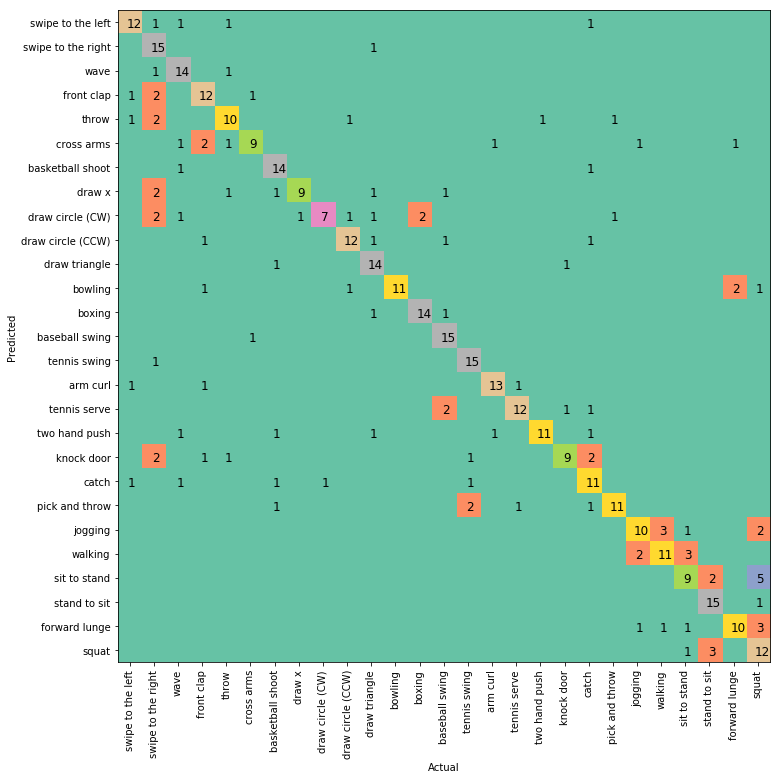

In [62]:
confusion_1 = confusion_matrix(np.argmax(Y_train, axis = -1), pred_1)
NUM_LABELS = 27

f, axes = plt.subplots(1,1, figsize = (12,12))
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.grid(False)
axes.set_xticklabels(class_labels, rotation = 90)
axes.set_yticklabels(class_labels)
axes.set_yticks(list(range(27)))
axes.set_xticks(list(range(27)))
plt.imshow(confusion_1, cmap=plt.cm.Set2, interpolation='nearest')

for i, cas in enumerate(confusion_1):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='black')

# Seeing if there is a bug

In [ ]:
for i in range(len(inertial_path)):
    test = sio.loadmat(inertial_path[i])['d_iner']
    test = np.expand_dims(np.swapaxes(sequence.pad_sequences(np.swapaxes(test,1,0), maxlen= 326), 1, 0), axis =0)
    pred = model.predict(test)
    print(np.argmax(pred, axis = -1) + 1, get_action_number(inertial_path[i]))

In [ ]:
num = 810

In [ ]:
test = sio.loadmat(inertial_path[num])['d_iner']

In [ ]:
test = np.expand_dims(np.swapaxes(sequence.pad_sequences(np.swapaxes(test,1,0), maxlen= 326), 1, 0), axis =0)

In [ ]:
pred = model.predict(test)

In [ ]:
np.argmax(pred, axis = -1), inertial_path[num].split('/')[-1]